In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:124: SyntaxWarning: invalid escape sequence '\D'
<>:90: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:124: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\1473689655.py:90: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_title(f"HODL vs Rebalanced vs LP, with $\mu = ${mu}, $\sigma = ${sigma}")
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\1473689655.py:90: SyntaxWarning: invalid escape sequence '\s'
  ax[0].set_title(f"HODL vs Rebalanced vs LP, with $\mu = ${mu}, $\sigma = ${sigma}")
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\1473689655.py:124: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\1473689655.py:92: UserWarning: No artists with labels found to put

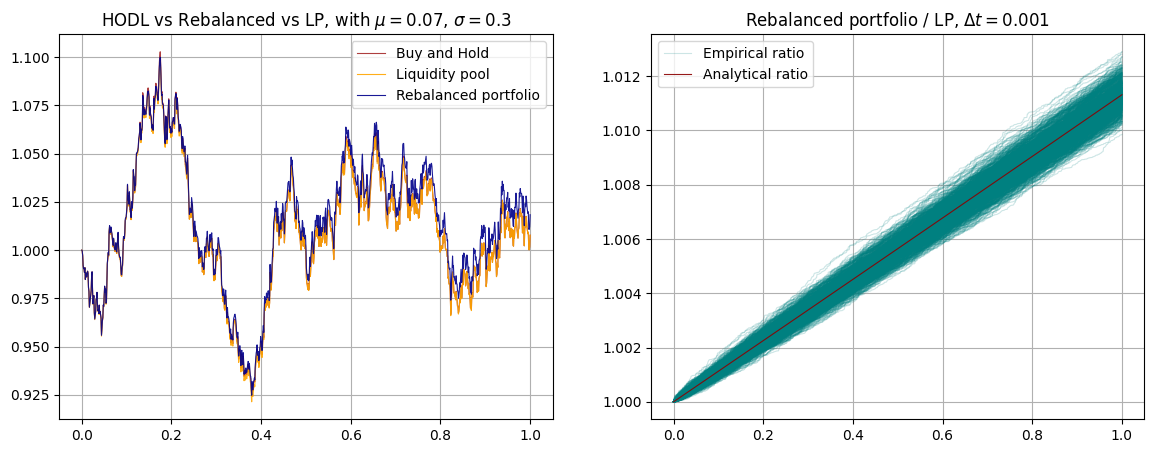

In [8]:
dt = 0.001
T = 1
t_array = np.arange(0, T+dt, dt)

mu = 0.07
sigma = 0.3
S_0 = 100

def simulate_gbm_OLD(mu, sigma, dt=0.01, T=1, S_0=100):
    t_array = np.arange(0, T+dt, dt)
    z_rand = np.random.normal(loc=0, scale=1, size=len(t_array))
    wienner_process = z_rand.cumsum()
    drift_arr = np.full(fill_value=(mu - np.pow(sigma, 2)/2)*dt, shape=len(t_array)).cumsum()

    gbm = S_0*np.exp(drift_arr + sigma*wienner_process)
    return gbm


def simulate_gbm(mu, sigma, t_array=None, dt=0.01, T=1, S_0=100):
    """
    Simulate a single path of Geometric Brownian Motion (GBM).

    Parameters
    ----------
    mu : float
        Drift coefficient (expected return)
    sigma : float
        Volatility coefficient
    t_array : array-like or None
        Optional. If provided, time points at which to simulate GBM.
        If None, generates np.arange(0, T + dt, dt).
    dt : float
        Time step size
    T : float
        Total simulation time
    S_0 : float
        Initial value (e.g., starting stock price)

    Returns
    -------
    t : np.ndarray
        Time array from 0 to T
    S : np.ndarray
        Simulated GBM values corresponding to t
    """

    # Use provided t_array or generate one
    if t_array is None:
        t_array = np.arange(0, T + dt, dt)
    else:
        dt = np.diff(t_array).mean()

    n_steps = len(t_array)
    # Generate random normal increments for Brownian motion
    dW = np.random.normal(0, np.sqrt(dt), size=n_steps - 1)
    W = np.concatenate(([0], np.cumsum(dW)))

    # Analytical GBM solution
    S = S_0 * np.exp((mu - 0.5 * sigma**2) * t_array + sigma * W)

    return S


c = 100
w_1 = 0.5
w_0 = 1 - w_1

N = 1000
gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
gbm_matrix = np.vstack(gbms).T
gbm_matrix = gbm_matrix / gbm_matrix[0]

# Simulating buy and hold
buy_n_hold_matrix = w_1*gbm_matrix + w_0*gbm_matrix[0]
buy_n_hold_matrix = buy_n_hold_matrix / buy_n_hold_matrix[0]

linewidth = 0.8
alpha = 0.9
alpha_low = 0.2

color_lp = 'orange'
color_rebalance = 'darkblue'
color_buy_n_hold = 'brown'

color_3 = 'teal'
color_4 = 'darkred'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax[0].set_title(f"HODL vs Rebalanced vs LP, with $\mu = ${mu}, $\sigma = ${sigma}")
ax[0].grid(True)
ax[0].legend()

for i in range(buy_n_hold_matrix.shape[1]-1):
    buy_n_hold = buy_n_hold_matrix[:, i]
    ######ax[0].plot(t_array, buy_n_hold, color=color_buy_n_hold, alpha=alpha, linewidth=linewidth)
ax[0].plot(t_array, buy_n_hold_matrix[:, -1], color=color_buy_n_hold, alpha=alpha, linewidth=linewidth, label='Buy and Hold')
#plt.hlines(y=1+np.log(gbms[-1][-1]/gbms[-1][0]), xmin=0, xmax=T)

s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
s_matrix = s_matrix / s_matrix[0]

for i in range(s_matrix.shape[1]-1):
    s = s_matrix[:, i]
    ######ax[0].plot(t_array, s, alpha=alpha, linewidth=linewidth, color=color_lp)
ax[0].plot(t_array, s_matrix[:, -1], alpha=alpha, linewidth=linewidth, color=color_lp, label='Liquidity pool')

gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

rebalance_matrix[1:] = rebalance_log_returns
rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
rebalance_matrix = np.exp(rebalance_matrix)
rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

for i in range(rebalance_matrix.shape[1]-1):
    X = rebalance_matrix[:, i]
    #####ax[0].plot(t_array, X, alpha=alpha, linewidth=linewidth, color=color_rebalance)
ax[0].plot(t_array, rebalance_matrix[:, -1], alpha=alpha, linewidth=linewidth, color=color_rebalance, label='Rebalanced portfolio')
ax[0].legend()

ax[1].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
diff_rebalance = rebalance_matrix / s_matrix
for i in range(rebalance_matrix.shape[1]-1):
    diff_arr = diff_rebalance[:, i]
    ax[1].plot(t_array, diff_arr, alpha=alpha_low, linewidth=linewidth, color=color_3)
ax[1].plot(t_array, diff_rebalance[:, -1], alpha=alpha_low, linewidth=linewidth, color=color_3, label=f'Empirical ratio')

#diff_rebalance_mean = np.mean(diff_rebalance, axis=1)
#plt.plot(t_array, diff_rebalance_mean, color=color_3, label='Mean value', alpha=0.3)

ax[1].plot(t_array, np.exp(sigma**2*t_array/8), color=color_4, label='Analytical ratio', linewidth=linewidth, alpha=alpha)
ax[1].legend()
ax[1].grid(True)

<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:117: SyntaxWarning: invalid escape sequence '\l'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:117: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\3273910254.py:108: SyntaxWarning: invalid escape sequence '\D'
  ax[ax_idx].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\3273910254.py:117: SyntaxWarning: invalid escape sequence '\l'
  ax[ax_idx].plot(t_array, np.exp(sigma**2*t_array/8), color=color_4, label='Analytical ratio $e^{\lambda t}$', linewidth=linewidth, alpha=alpha)


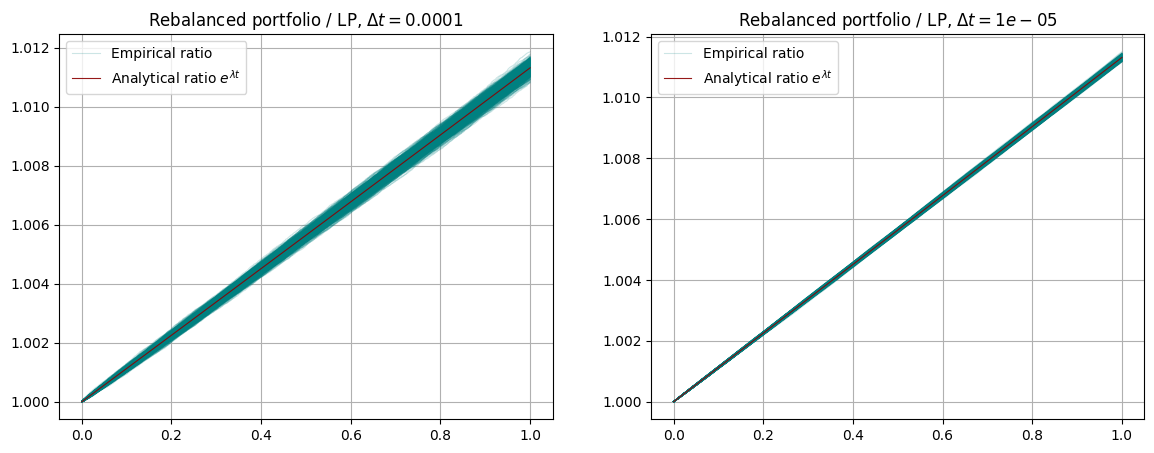

In [7]:
dt = 0.001
T = 1
t_array = np.arange(0, T+dt, dt)

mu = 0.07
sigma = 0.3
S_0 = 100

def simulate_gbm(mu, sigma, t_array=None, dt=0.01, T=1, S_0=100):
    """
    Simulate a single path of Geometric Brownian Motion (GBM).

    Parameters
    ----------
    mu : float
        Drift coefficient (expected return)
    sigma : float
        Volatility coefficient
    t_array : array-like or None
        Optional. If provided, time points at which to simulate GBM.
        If None, generates np.arange(0, T + dt, dt).
    dt : float
        Time step size
    T : float
        Total simulation time
    S_0 : float
        Initial value (e.g., starting stock price)

    Returns
    -------
    t : np.ndarray
        Time array from 0 to T
    S : np.ndarray
        Simulated GBM values corresponding to t
    """

    # Use provided t_array or generate one
    if t_array is None:
        t_array = np.arange(0, T + dt, dt)
    else:
        dt = np.diff(t_array).mean()

    n_steps = len(t_array)
    # Generate random normal increments for Brownian motion
    dW = np.random.normal(0, np.sqrt(dt), size=n_steps - 1)
    W = np.concatenate(([0], np.cumsum(dW)))

    # Analytical GBM solution
    S = S_0 * np.exp((mu - 0.5 * sigma**2) * t_array + sigma * W)

    return S


c = 100
w_1 = 0.5
w_0 = 1 - w_1

N = 1000
gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
gbm_matrix = np.vstack(gbms).T
gbm_matrix = gbm_matrix / gbm_matrix[0]

s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
s_matrix = s_matrix / s_matrix[0]

linewidth = 0.8
alpha = 0.9
alpha_low = 0.2

color_lp = 'orange'
color_rebalance = 'darkblue'
color_buy_n_hold = 'brown'

color_3 = 'teal'
color_4 = 'darkred'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

rebalance_matrix[1:] = rebalance_log_returns
rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
rebalance_matrix = np.exp(rebalance_matrix)
rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

def plot_sim(dt, ax_idx):
    t_array = np.arange(0, T+dt, dt)
    gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
    gbm_matrix = np.vstack(gbms).T
    gbm_matrix = gbm_matrix / gbm_matrix[0]

    s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
    s_matrix = s_matrix / s_matrix[0]

    gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
    rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

    rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

    rebalance_matrix[1:] = rebalance_log_returns
    rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
    rebalance_matrix = np.exp(rebalance_matrix)
    rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

    ax[ax_idx].set_title(f"Rebalanced portfolio / LP, $\Delta t = {dt}$")
    diff_rebalance = rebalance_matrix / s_matrix
    for i in range(rebalance_matrix.shape[1]-1):
        diff_arr = diff_rebalance[:, i]
        ax[ax_idx].plot(t_array, diff_arr, alpha=alpha_low, linewidth=linewidth, color=color_3)
    ax[ax_idx].plot(t_array, diff_rebalance[:, -1], alpha=alpha_low, linewidth=linewidth, color=color_3, label=f'Empirical ratio')

    #diff_rebalance_mean = np.mean(diff_rebalance, axis=1)
    #plt.plot(t_array, diff_rebalance_mean, color=color_3, label='Mean value', alpha=0.3)
    ax[ax_idx].plot(t_array, np.exp(sigma**2*t_array/8), color=color_4, label='Analytical ratio $e^{\lambda t}$', linewidth=linewidth, alpha=alpha)
    ax[ax_idx].legend()
    ax[ax_idx].grid(True)
plot_sim(dt=0.0001, ax_idx=0)
plot_sim(dt=0.00001, ax_idx=1)

<>:77: SyntaxWarning: invalid escape sequence '\l'
<>:77: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\3621193474.py:77: SyntaxWarning: invalid escape sequence '\l'
  ax[1].plot(t_array_2, np.exp(l*x_array_2), linewidth=linewidth, alpha=alpha, color=color_4, label='Analytical ratio $e^{\lambda t}$')
C:\Users\jens2\AppData\Local\Temp\ipykernel_33036\3621193474.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers, start='2020-01-01', end='2021-01-01', multi_level_index=False)
[*********************100%***********************]  4 of 4 completed


Price         Close                      Cash
Ticker          AAL    CCL   NCLH    OXY     
Price Ticker                                 
Close AAL     1.089  0.870  1.034  0.534  0.0
      CCL     0.870  1.465  1.381  0.778  0.0
      NCLH    1.034  1.381  1.740  0.821  0.0
      OXY     0.534  0.778  0.821  1.202  0.0
Cash          0.000  0.000  0.000  0.000  0.0
0.5495923413469495 0.3266387715107683
0.22295356983618114
Price  Ticker
Close  AAL      -45.59
       CCL      -57.29
       NCLH     -56.77
       OXY      -58.03
Cash              0.00
dtype: float64


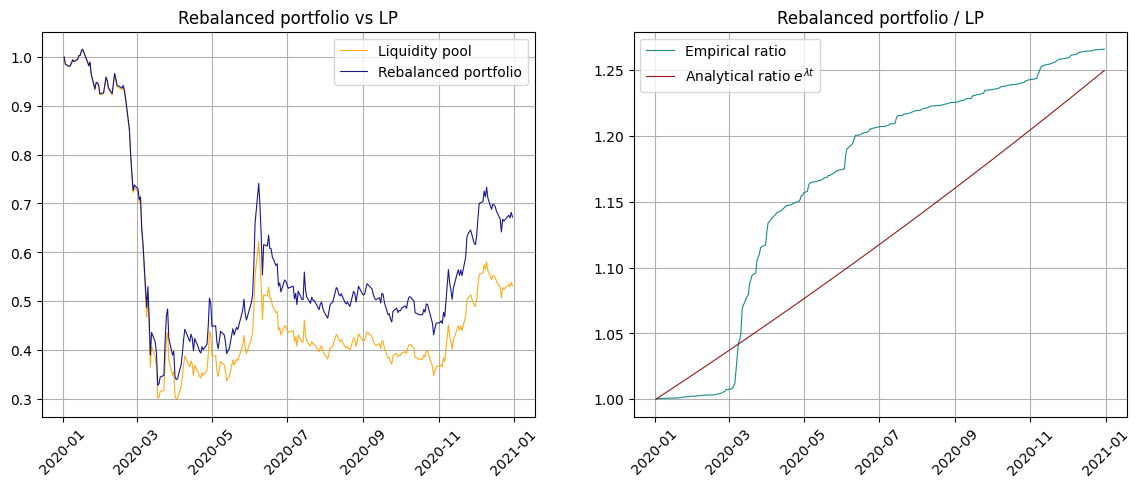

In [4]:
#tickers = ['AAPL', 'MSFT', 'BTC-USD', 'ETH-USD', 'USD']
tickers = ['CCL', 'NCLH', 'OXY', 'AAL']

# tickers = [
#     "JNJ",    # Johnson & Johnson – healthcare
#     "KO",     # Coca-Cola – beverages
#     "PEP",    # PepsiCo – beverages and snacks
#     "WMT",    # Walmart – retail
#     "CL",     # Colgate-Palmolive – personal care
#     "MDT",    # Medtronic – medical devices
#     "MCD"    # McDonald's – fast food
# ]

df = yf.download(tickers=tickers, start='2020-01-01', end='2021-01-01', multi_level_index=False)
#df = yf.download(tickers=tickers, interval='1m', period='7d')
df = df[['Close']]

df['Cash'] = 100
df = df.dropna()

N_assets = len(df.columns)
w_vector = np.ones(shape=N_assets) / N_assets

def get_lambda(df, w_vector):
    df_returns = df.pct_change().dropna() - 1
    cov_matrix = df_returns.cov().to_numpy() * 252
    print(np.round(252*df_returns.cov(), 3))

    a = np.dot(w_vector, np.diag(cov_matrix)) / 2
    b = w_vector @ cov_matrix @ w_vector.T / 2
    print(a, b)
    return a - b

l = get_lambda(df, w_vector)
print(l)

print(np.round(100*(df.iloc[-1] / df.iloc[0] - 1), 2))

def compute_st_value(df_prices, w_vector, s_0=1):
    data_np = df_prices.to_numpy()
    data_log_weighted = w_vector*np.log(data_np)
    y = np.exp(np.sum(data_log_weighted, axis=1))
    y = s_0 * (y / y[0])

    return y

def compute_Xt_value(df_prices, w_vector, X_0=1):
    data_np = df_prices.to_numpy()
    log_returns = np.log((data_np[1:] / data_np[:-1]) @ w_vector.T)
    rebalance_array = np.full(shape=data_np.shape[0],fill_value=np.log(X_0))

    rebalance_array[1:] = log_returns
    rebalance_value = np.cumsum(rebalance_array)
    rebalance_value = np.exp(rebalance_value)
    
    return rebalance_value

s_t = compute_st_value(df, w_vector, 1)
X_t = compute_Xt_value(df, w_vector, 1)

t_0 = df.index[0].timestamp()
t_1 = df.index[-1].timestamp()
t_array_2 = pd.date_range(start=df.index[0], end=df.index[-1], periods=1000)
x_array_2 = np.linspace(0, 1, len(t_array_2))

fix, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

for axi in ax.flat:
    axi.grid(True)  # Turn on grid

ax[0].plot(df.index, s_t, linewidth=linewidth, alpha=alpha, color=color_lp, label='Liquidity pool')
ax[0].plot(df.index, X_t, linewidth=linewidth, alpha=alpha, color=color_rebalance, label='Rebalanced portfolio')
ax[0].set_title("Rebalanced portfolio vs LP")
ax[0].legend()

ax[1].plot(df.index, X_t/s_t, linewidth=linewidth, alpha=alpha, color=color_3, label='Empirical ratio')
ax[1].plot(t_array_2, np.exp(l*x_array_2), linewidth=linewidth, alpha=alpha, color=color_4, label='Analytical ratio $e^{\lambda t}$')
ax[1].set_title("Rebalanced portfolio / LP")
ax[1].legend()
for axi in ax.flat:
    axi.tick_params(axis='x', labelrotation=45)
plt.show()